In [1]:
# =========================
# 0) Setup
# =========================
!pip -q install -U transformers datasets accelerate scikit-learn

from google.colab import drive
drive.mount("/content/drive")

import os, numpy as np, pandas as pd, torch
from sklearn.metrics import f1_score, accuracy_score
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding, set_seed
)

SEED = 42
set_seed(SEED)

IN_PATH  = "/content/drive/MyDrive/master_with_teacherA_logits.csv"
OUT_DIR  = "/content/drive/MyDrive/student_xlmr_base_distill"
os.makedirs(OUT_DIR, exist_ok=True)

MODEL_NAME = "xlm-roberta-base"
MAX_LEN = 256
VAL_FRAC = 0.05

# distill mixing: trust GT more
ALPHA_GT = 0.7   # CE weight
EPS = 1e-6


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 56.8 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
# =========================
# 1) Load + build internal train/val split (from split=="train")
# =========================
df = pd.read_csv(IN_PATH, low_memory=False)

# keep labeled train only
df = df[df["split"].astype(str).eq("train")].copy()
df = df[df["polarized"].notna()].copy()
df["labels"] = df["polarized"].astype(int)

# teacher availability
df["has_teacher"] = df["teacherA_p1"].notna().astype(int)
df["teacher_p1"] = df["teacherA_p1"].fillna(-1.0).astype(float)

# stratified-by-(lang,label) split
train_parts, val_parts = [], []
rng = np.random.RandomState(SEED)

for lang, sub in df.groupby("lang", sort=False):
    for y in [0, 1]:
        g = sub[sub["labels"] == y]
        if len(g) == 0:
            continue
        g = g.sample(frac=1, random_state=SEED)
        n_val = max(1, int(len(g) * VAL_FRAC)) if len(g) > 1 else 0
        val_parts.append(g.iloc[:n_val])
        train_parts.append(g.iloc[n_val:])

train_df = pd.concat(train_parts, ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)
val_df   = pd.concat(val_parts,   ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)

print("train:", train_df.shape, "val:", val_df.shape)
print("val macro label dist:\n", val_df["labels"].value_counts(normalize=True))
print("val teacher coverage:", val_df["has_teacher"].mean())


train: (70016, 17) val: (3665, 17)
val macro label dist:
 labels
1    0.531787
0    0.468213
Name: proportion, dtype: float64
val teacher coverage: 0.9574351978171897


In [5]:
# =========================
# 2) HF Datasets + Tokenize (student input is ORIGINAL text)
# =========================

from datasets import Dataset
import numpy as np

keep_cols = ["id", "text", "labels", "teacher_p1", "has_teacher"]
train_ds = Dataset.from_pandas(train_df[keep_cols], preserve_index=False)
val_ds   = Dataset.from_pandas(val_df[keep_cols], preserve_index=False)

def tok_fn(batch):
    return tok(batch["text"], truncation=True, max_length=MAX_LEN)

train_ds = train_ds.map(tok_fn, batched=True)
val_ds   = val_ds.map(tok_fn, batched=True)

# IMPORTANT: remove only 'text' (keep teacher_p1/has_teacher)
train_ds = train_ds.remove_columns(["text", "id"])
val_ds   = val_ds.remove_columns(["text", "id"])

cols = ["input_ids", "attention_mask", "labels", "teacher_p1", "has_teacher"]
if "token_type_ids" in train_ds.column_names:
    cols.append("token_type_ids")

train_ds.set_format(type="torch", columns=cols)
val_ds.set_format(type="torch", columns=cols)

print("train columns:", train_ds.column_names)
print("val columns:", val_ds.column_names)



Map:   0%|          | 0/70016 [00:00<?, ? examples/s]

Map:   0%|          | 0/3665 [00:00<?, ? examples/s]

train columns: ['labels', 'teacher_p1', 'has_teacher', 'input_ids', 'attention_mask']
val columns: ['labels', 'teacher_p1', 'has_teacher', 'input_ids', 'attention_mask']


In [4]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("xlm-roberta-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [6]:
import torch
from transformers import DataCollatorWithPadding

padder = DataCollatorWithPadding(tok, return_tensors="pt")

def distill_collator(features):
    token_keys = ["input_ids", "attention_mask"]
    token_feats = [{k: f[k] for k in token_keys} for f in features]
    batch = padder(token_feats)

    batch["labels"] = torch.tensor([f["labels"] for f in features], dtype=torch.long)
    batch["teacher_p1"] = torch.tensor([f.get("teacher_p1", -1.0) for f in features], dtype=torch.float32)
    batch["has_teacher"] = torch.tensor([f.get("has_teacher", 0) for f in features], dtype=torch.long)

    return batch


In [7]:
# =========================
# 3) Custom Trainer: CE on all, + KL distill where teacher exists
# =========================
import torch.nn.functional as F

class DistillTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        teacher_p1 = inputs.pop("teacher_p1")
        has_teacher = inputs.pop("has_teacher")

        outputs = model(**inputs)
        logits = outputs.logits

        # GT loss (all)
        ce = F.cross_entropy(logits, labels)

        # Distill loss (only where teacher exists)
        mask = has_teacher.bool()
        if mask.any():
            lp = F.log_softmax(logits[mask], dim=-1)

            p1 = teacher_p1[mask].clamp(EPS, 1 - EPS)
            tp = torch.stack([1 - p1, p1], dim=-1)  # [n,2]
            kl = F.kl_div(lp, tp, reduction="batchmean")
            loss = ALPHA_GT * ce + (1 - ALPHA_GT) * kl
        else:
            loss = ce

        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "acc": float(accuracy_score(labels, preds)),
        "f1_macro": float(f1_score(labels, preds, average="macro")),
    }


In [9]:
# =========================
# 4) Train student
# =========================
from transformers import EarlyStoppingCallback

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

args = TrainingArguments(
    output_dir=OUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=2,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,  # effective 32

    num_train_epochs=5,
    learning_rate=1e-5,
    warmup_ratio=0.06,
    weight_decay=0.01,
    max_grad_norm=1.0,

    bf16=True,
    fp16=False,

    logging_steps=100,
    report_to="none",

    seed=SEED,
    data_seed=SEED,

    remove_unused_columns=False,
)

trainer = DistillTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tok,
    data_collator=distill_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)


trainer.train()
trainer.evaluate()

# save FINAL best model + tokenizer
final_dir = os.path.join(OUT_DIR, "FINAL")
trainer.save_model(final_dir)
tok.save_pretrained(final_dir)
print("Saved FINAL student to:", final_dir)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3323974733.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillTrainer.__init__`. Use `processing_class` instead.
  trainer = DistillTrainer(


Epoch,Training Loss,Validation Loss,Acc,F1 Macro
1,0.464300,0.437416,0.791814,0.790977
2,0.412900,0.421905,0.796999,0.796386
3,0.383900,0.425485,0.810368,0.810024
4,0.355800,0.450719,0.809004,0.808940


Saved FINAL student to: /content/drive/MyDrive/student_xlmr_base_distill/FINAL


## Reporting Student Results

In [10]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    average_precision_score,
    precision_recall_curve,
)

pred = trainer.predict(val_ds)
logits = pred.predictions
y_true = pred.label_ids.astype(int)

# probs for positive class
probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
p1 = probs[:, 1]
y_pred = (p1 >= 0.5).astype(int)

acc = accuracy_score(y_true, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)

print("Accuracy:", acc)
print("Macro Precision:", prec_macro)
print("Macro Recall:", rec_macro)
print("Macro F1:", f1_macro)


Accuracy: 0.810368349249659
Macro Precision: 0.8098271232857123
Macro Recall: 0.810939893867036
Macro F1: 0.8100241581653905


## Confusion Matrix

Confusion matrix [[TN, FP],[FN, TP]]:
 [[1407  309]
 [ 386 1563]]


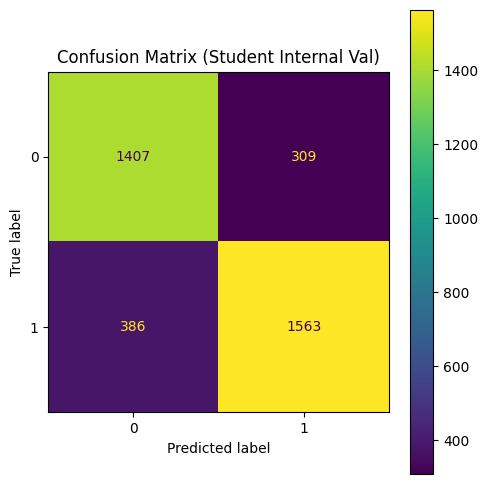

Saved: /content/drive/MyDrive/student_xlmr_base_distill/confusion_matrix_internal_val.png


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)  # [[TN,FP],[FN,TP]]
print("Confusion matrix [[TN, FP],[FN, TP]]:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, values_format="d")
ax.set_title("Confusion Matrix (Student Internal Val)")
plt.tight_layout()

out_cm = os.path.join(OUT_DIR, "confusion_matrix_internal_val.png")
plt.savefig(out_cm, dpi=200)
plt.show()
print("Saved:", out_cm)

## Precision–Recall Curve

Average Precision (PR-AUC): 0.8863549908613165


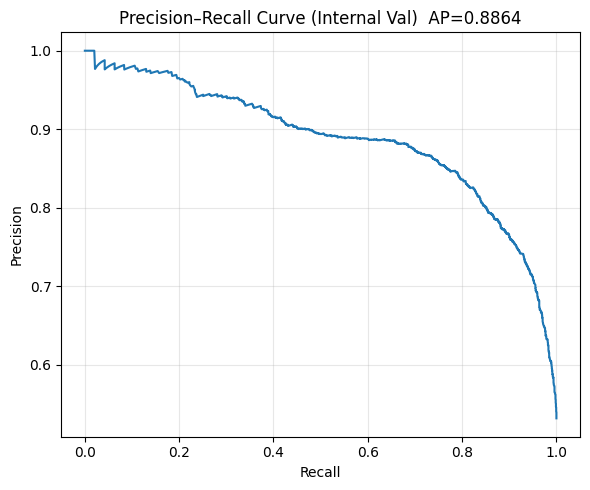

Saved: /content/drive/MyDrive/student_xlmr_base_distill/pr_curve_internal_val.png


In [12]:
prec, rec, _ = precision_recall_curve(y_true, p1)
ap = average_precision_score(y_true, p1)
print("Average Precision (PR-AUC):", ap)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(rec, prec)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title(f"Precision–Recall Curve (Internal Val)  AP={ap:.4f}")
ax.grid(True, alpha=0.3)
plt.tight_layout()

out_pr = os.path.join(OUT_DIR, "pr_curve_internal_val.png")
plt.savefig(out_pr, dpi=200)
plt.show()
print("Saved:", out_pr)

## Final Student (All training data without internal split)

In [ ]:
from datasets import Dataset
from transformers import AutoModelForSequenceClassification

# 1) load all labeled train
full_df = pd.read_csv(IN_PATH, low_memory=False)
full_df = full_df[full_df["split"].astype(str).eq("train")].copy()
full_df = full_df[full_df["polarized"].notna()].copy()

full_df["labels"] = full_df["polarized"].astype(int)
full_df["has_teacher"] = full_df["teacherA_p1"].notna().astype(int)
full_df["teacher_p1"] = full_df["teacherA_p1"].fillna(-1.0).astype(float)

full_ds = Dataset.from_pandas(full_df[keep_cols], preserve_index=False)

def tok_fn_full(batch):
    return tok(batch["text"], truncation=True, max_length=MAX_LEN)

full_ds = full_ds.map(tok_fn_full, batched=True)
full_ds = full_ds.remove_columns(["text", "id"])

# 2) new output dir
final_train_dir = os.path.join(OUT_DIR, "FINAL_TRAIN")
args_final = TrainingArguments(
    output_dir=final_train_dir,
    eval_strategy="no",          # no internal val now
    save_strategy="epoch",
    save_total_limit=2,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    num_train_epochs=5,          # same as best run
    learning_rate=1e-5,          # same as best run
    warmup_ratio=0.06,
    weight_decay=0.01,
    max_grad_norm=1.0,

    bf16=True,
    fp16=False,

    logging_steps=100,
    report_to="none",

    seed=SEED,
    data_seed=SEED,

    remove_unused_columns=False,  # IMPORTANT for teacher_p1
)

# 3) init from best student
best_student_dir = os.path.join(OUT_DIR, "FINAL")  # from trainer.save_model(final_dir)
model2 = AutoModelForSequenceClassification.from_pretrained(best_student_dir, num_labels=2)

trainer2 = DistillTrainer(
    model=model2,
    args=args_final,
    train_dataset=full_ds,
    tokenizer=tok,
    data_collator=distill_collator,
    compute_metrics=compute_metrics,
)

trainer2.train()

# 4) save final
final_out = os.path.join(final_train_dir, "FINAL")
trainer2.save_model(final_out)
tok.save_pretrained(final_out)
print("Saved FINAL trained-on-all to:", final_out)


Map:   0%|          | 0/73681 [00:00<?, ? examples/s]

/tmp/ipython-input-522653001.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillTrainer.__init__`. Use `processing_class` instead.
  trainer2 = DistillTrainer(


Step,Training Loss
100,0.332600
200,0.336500
300,0.338100
400,0.331500
500,0.340000
600,0.357500
700,0.352800
800,0.364000
900,0.350600
1000,0.352000


Saved FINAL trained-on-all to: /content/drive/MyDrive/student_xlmr_base_distill/FINAL_TRAIN/FINAL
